# Setup

In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: rich_clust
python version: 3.9.12


In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch
# from kymatio.torch import Scattering2D

import gc
import time
import functools
import multiprocessing as mp


In [3]:
# params = {
#     'dir_github': r'/media/rich/Home_Linux_partition/github_repos/',
#     'dir_allOuterFolders': r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp10",
#     'pathSuffixToStat': 'plane1/stat.npy',
#     'pathSuffixToOps': 'plane1/ops.npy',
#     'pref_use_NN_distances': True,
#     'use_GPU': True,
#     'pref_blurROIs': True,
#     'params_blur': {
#         'kernel_size': 7, # Edge length of kernel image. Make odd number.
#         'kernel_width': 2.1, # width of 1 full cosine cycle for the 2d cosine kernel. Use width=2 for a single pixel.
#     },
#     'mask_power': 1, ## This parameter determines how 'binary'-looking masks are. Small values = more binary. Large values weight bright pixels more. mask_scaled = mask**mask_power
#     'params_dIOU': {
#         'algorithm': 'brute', ## Can be 'brute', 'auto', or anything from sklearn.neighbors.NearestNeighbors
#         'n_neighbors': 'full', ## Can either be an int or 'full', in which case the output will not be sparse
#     }
# }

In [4]:
dir_github = Path(r'/media/rich/Home_Linux_partition/github_repos/').resolve()

import sys
sys.path.append(str(dir_github))

In [5]:
# device = torch_helpers.set_device(use_GPU=params['use_GPU'])

In [6]:
%load_ext autoreload
%autoreload 2
from ROICaT.tracking import data_importing, visualization, alignment, blurring, helpers, ROInet, scatteringWaveletTransformer, similarity_graph, clustering

In [7]:
%matplotlib notebook

# Import paths

In [8]:
def print_list(l):
    for item in l:
        print(item)

In [9]:
dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()

folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])

dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'plane0/stat.npy'
pathSuffixToOps = 'plane0/ops.npy'

paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]

print(f'folder names of all sessions: \n{folders_allSessions}')
print(f'paths to all stat files: \n{paths_allStat}')


folder names of all sessions: 
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14']
paths to all stat files: 
[PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D1/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D2/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D3/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D4/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D5/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16/D6/plane0/stat.npy')
 PosixPath('/media/rich/bigSSD/

# Import data

In [10]:
data = data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    verbose=True,
)

data.import_statFiles();

data.import_ROI_centeredImages(
    out_height_width=[72,72],
    max_footprint_width=1025,
);

data.import_FOV_images(
    type_meanImg='meanImgE',
    images=None
);

data.import_ROI_spatialFootprints(workers=-1);

Starting: Importing spatial footprints from stat files
Completed: Imported 14 stat files into class as self.statFiles. Total number of ROIs: 51169. Number of ROI from each file: [3047, 2847, 2779, 4324, 4264, 3369, 3514, 3620, 4375, 3768, 4829, 2994, 3439, 4000]


14it [00:02,  6.03it/s]


Converted 14 spatial footprint files into small centered images in self.ROI_images.
Imported 14 FOV images into class as self.FOV_images
Importing spatial footprints from stat files.
Imported 14 sessions of spatial footprints into sparse arrays.


<IPython.core.display.Javascript object>


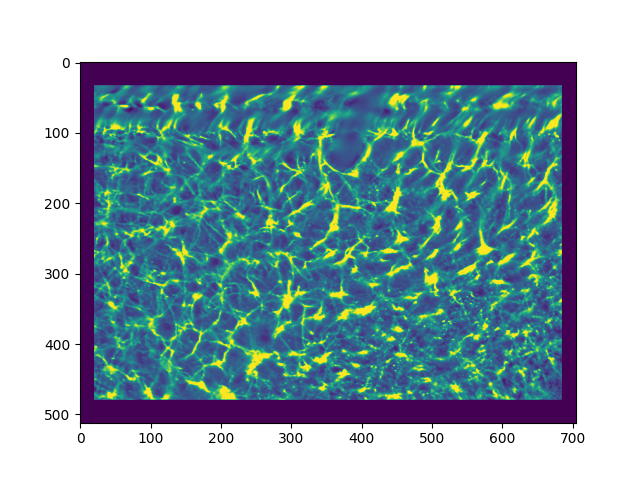

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


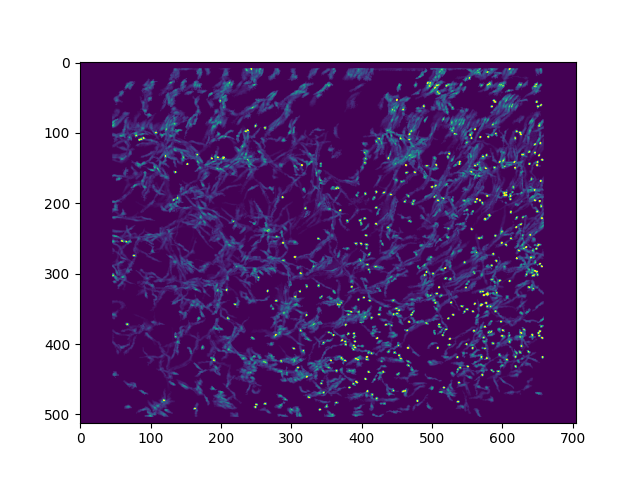

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


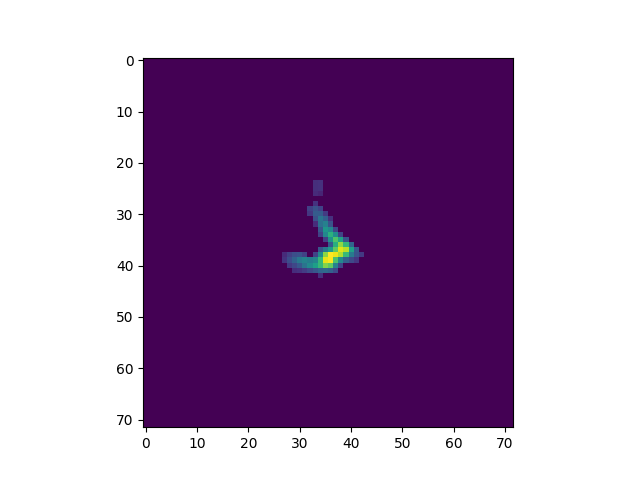

interactive(children=(IntSlider(value=0, description='i_frame', max=51168), Output()), _dom_classes=('widget-i…

In [69]:
%matplotlib notebook

visualization.display_toggle_image_stack(data.FOV_images)

visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [30]:
use_CLAHE = False
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in pcr.ims_registered[:]] if use_CLAHE else data.FOV_images

pcr = alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    im_template=FOV_images[idx_st],
    ims_moving=FOV_images
);

aligner = alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    templateFOV=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

100%|███████████████████████████████████████████| 14/14 [04:36<00:00, 19.71s/it]


<IPython.core.display.Javascript object>


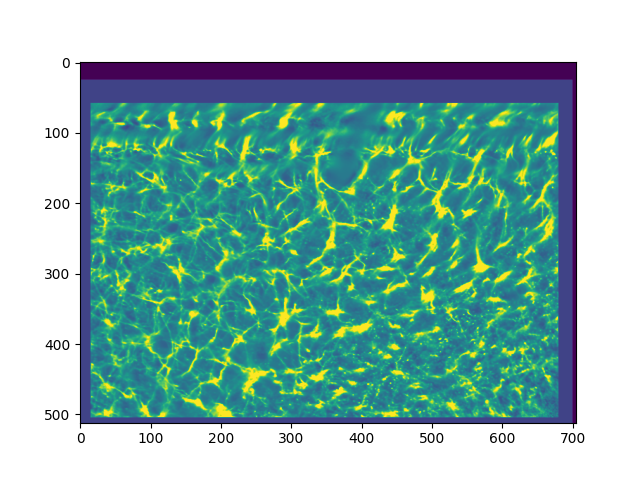

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


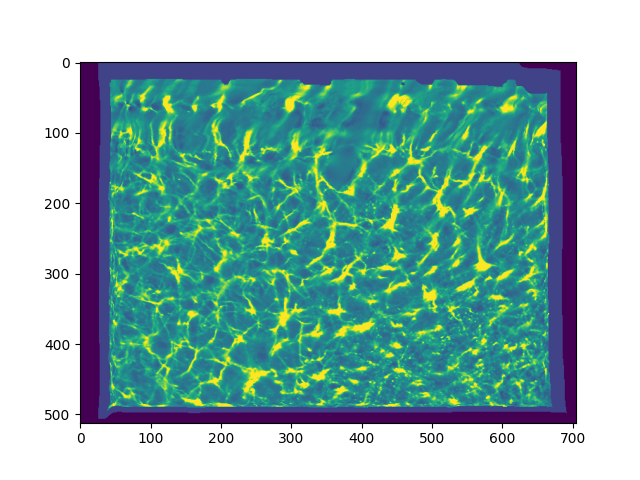

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


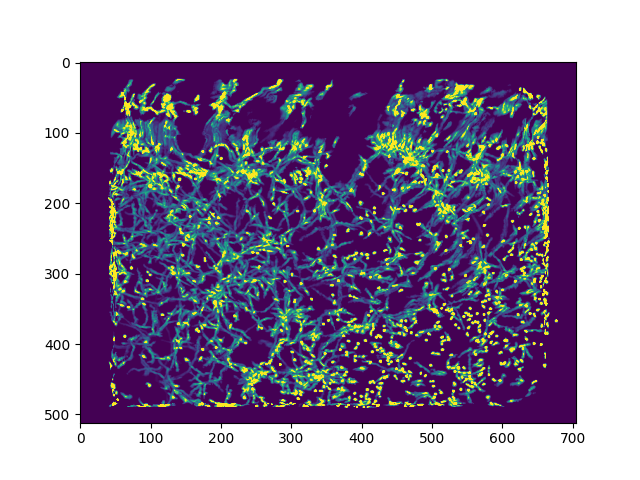

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

<IPython.core.display.Javascript object>


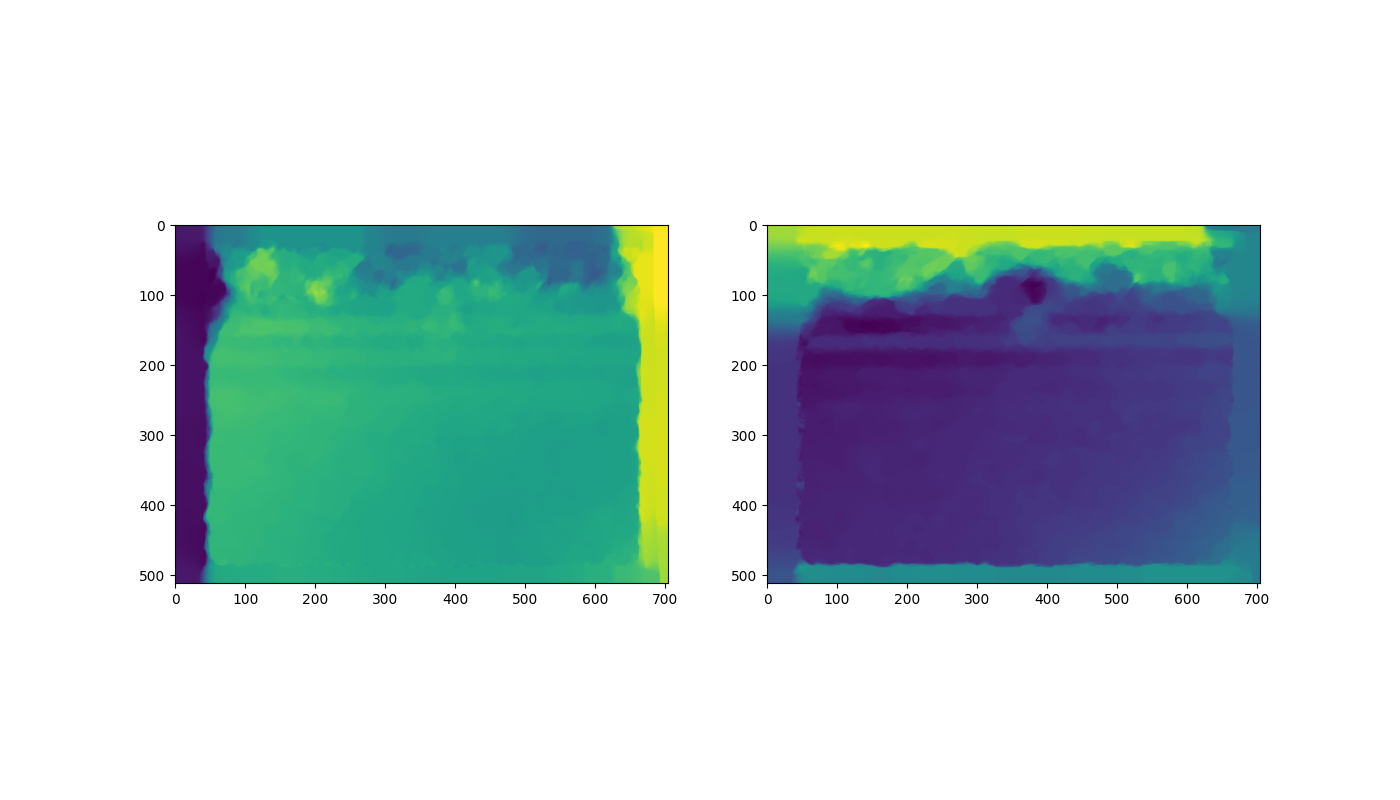

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [31]:
%matplotlib notebook

visualization.display_toggle_image_stack(pcr.ims_registered[:])

visualization.display_toggle_image_stack(aligner.FOVs_aligned)
visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
visualization.display_toggle_2channel_image_stack(aligner.flows)

## Blur ROIs (optional)

In [32]:
blurrer = blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


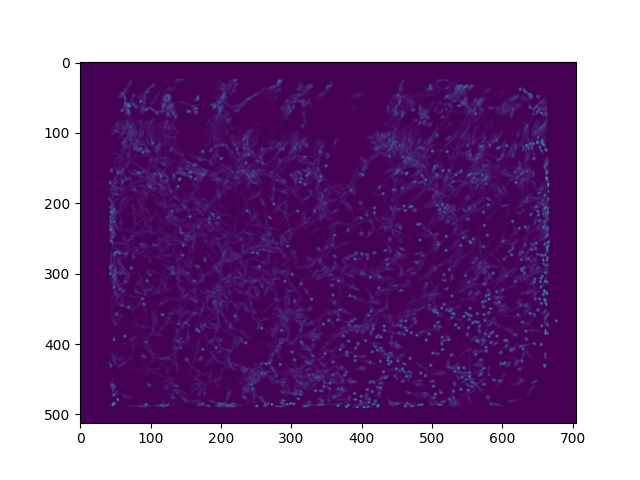

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [33]:
%matplotlib notebook
visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

## Neural network embedding distances

In [19]:
# data.um_per_pixel = 2.0

In [46]:

hash_dict_true = {
    'params': ('params.json', '68cf1bd47130f9b6d4f9913f86f0ccaa'),
    'model': ('model.py', '61c85529b7aa33e0dfadb31ee253a7e1'),
    'state_dict': ('ConvNext_tiny__1_0_best__simCLR.pth', '3287e001ff28d07ada2ae70aa7d0a4da'),
}

roinet = ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles='/home/rich/Downloads/ROInet',
    
#     download_from_gDrive='force_download',
#     download_from_gDrive='force_local',
    download_from_gDrive='check_local_first',
    gDriveID='1D2Qa-YUNX176Q-wgboGflW0K6un7KYeN',
    hash_dict_networkFiles=hash_dict_true,
#     hash_dict_networkFiles=None,
    forward_pass_version='latent',
    verbose=True,
)

Successful hash comparison. Found matching files: {'params': '/home/rich/Downloads/ROInet/params.json', 'model': '/home/rich/Downloads/ROInet/model.py', 'state_dict': '/home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth'}
Imported model from /home/rich/Downloads/ROInet/model.py
Loaded params_model from /home/rich/Downloads/ROInet/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Downloads/ROInet/ConvNext_tiny__1_0_best__simCLR.pth
Loaded network onto device cuda:0


In [47]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

Starting: resizing ROIs


100%|███████████████████████████████████████████| 14/14 [00:14<00:00,  1.05s/it]


Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


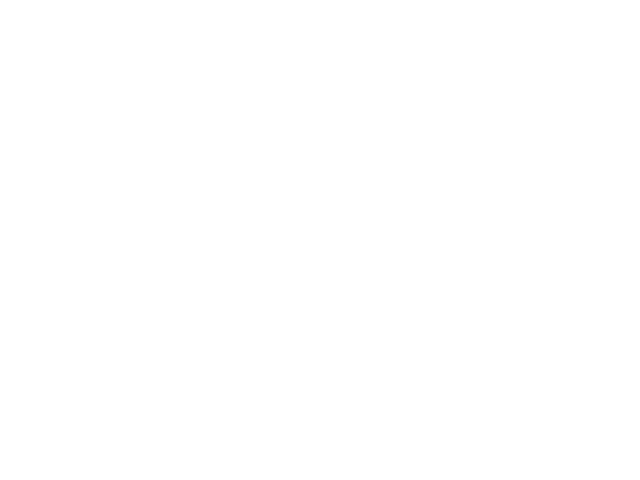

interactive(children=(IntSlider(value=0, description='i_frame', max=51168), Output()), _dom_classes=('widget-i…

In [48]:
%matplotlib notebook
visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [49]:
roinet.generate_latents();


starting: running data through network


  0%|                                                  | 0/6397 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node 

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %253 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile informati

completed: running data through network


In [50]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

## Scattering wavelet embedding distances

In [51]:
swt = scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


  0%|                                                | 0/511.69 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/tqdm/std.py:533: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|█████████████████████████████████████| 512/511.69 [00:02<00:00, 211.30it/s]

Completed: SWT transform on ROIs


In [52]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


## Compute similarities

In [79]:
sim = similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    overlapping_width_Multiplier=0.0,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

<IPython.core.display.Javascript object>


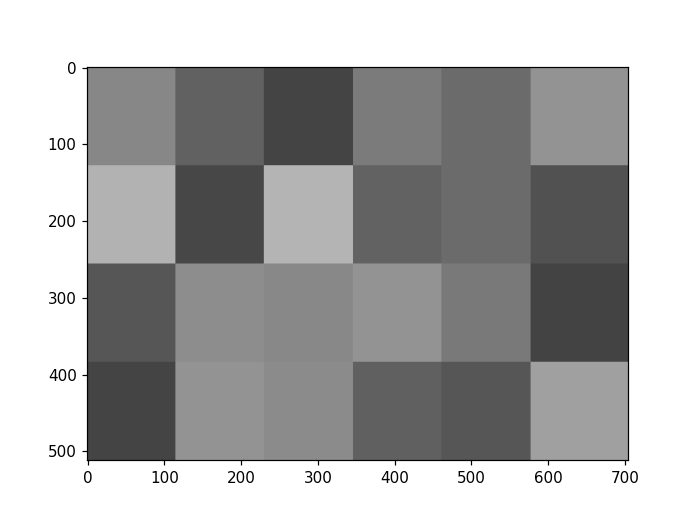

In [80]:
sim.visualize_blocks()

In [81]:
s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=0.8,
);

Computing pairwise similarity between ROIs...


100%|███████████████████████████████████████████| 24/24 [00:57<00:00,  2.38s/it]


Joining blocks into full similarity matrices...


In [576]:
sim.make_normalized_similarities(
    centers_of_mass=data.get_midCoords(),
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
)

Normalizing Neural Network similarity scores...


100%|██████████████████████████████████| 51169/51169 [00:03<00:00, 14388.54it/s]


Normalizing SWT similarity scores...


100%|████████████████████████████████████| 51169/51169 [02:32<00:00, 336.12it/s]


# Clustering

Making conjunctive distance matrix...


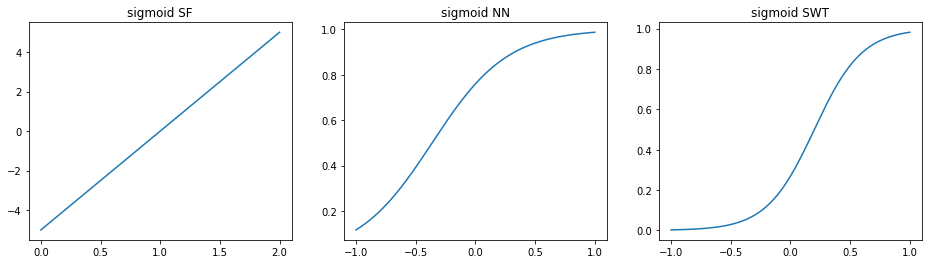

In [621]:
%matplotlib inline
clusterer = clustering.Clusterer()

clusterer.make_conjunctive_distance_matrix(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
#     s_SWT_z=None,
    power_sf= 1.1283032403078765,
    power_NN=0.4728813120992312,
    power_SWT=1,
    p_norm=-8.81737558074308,
#     sig_sf_kwargs={'mu':1.0, 'b':0.5},
    sig_sf_kwargs=None,
    sig_NN_kwargs={'mu':-1.808633200907082, 'b':0.635134494015924,},
    sig_SWT_kwargs={'mu':1, 'b':1},
    plot_sigmoid=True,
)

In [667]:
best_params

{'power_sf': 0.3582257559364649,
 'power_NN': 1.421879514461546,
 'power_SWT': 0.24238872632953112,
 'p_norm': -6.0714284193548105,
 'sig_NN_kwargs': {'mu': -2.934935684773385, 'b': 4.120407687873644},
 'sig_SWT_kwargs': {'mu': -3.8377466317761715, 'b': 3.261410173836138}}

Pruning similarity graphs with 818 bins and smoothing window 8...
Making conjunctive distance matrix...
Finding intermode cutoff...
Using intermode cutoff of 0.147


<IPython.core.display.Javascript object>


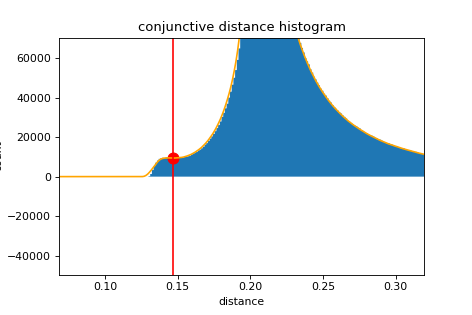

In [804]:
clusterer = clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,

)

%matplotlib notebook
clusterer.prune_similarity_graphs(
    fallback_d_cutoff=0.5,
    plot_pref=True,
    kwargs_makeConjunctiveDistanceMatrix={
        'power_sf': 0.5,
        'power_NN': 1.0,
        'power_SWT': 0.1,
        'p_norm': -4.0,
        'sig_NN_kwargs': {'mu': -1.5, 'b': 1.0},
        'sig_SWT_kwargs': {'mu': -2.0, 'b': 1.0}
    },
)

# clusterer.make_conjunctive_distance_matrix(
# #     s_SWT_z=None,
#     sig_sf_kwargs=None,
#     **best_params
# )

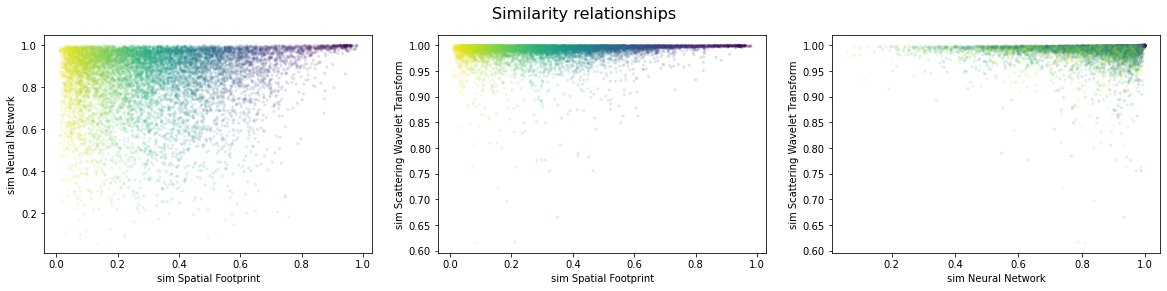

In [769]:
# %matplotlib inline
clusterer.plot_similarity_relationships(plots_to_show=[1,2,3], max_samples=10000, kwargs_scatter={'s':5, 'alpha':0.1});

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<IPython.core.display.Javascript object>


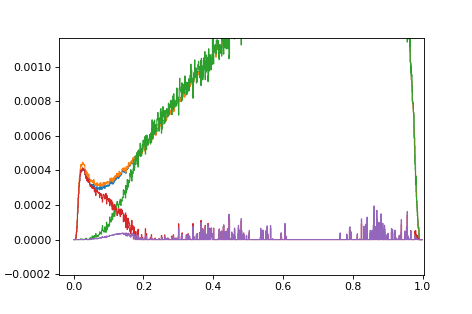

(-0.001, 0.025)

In [727]:
edges = np.linspace(0,1,1000)
centers = np.stack((edges[1:], edges[:-1]), axis=0).max(0)

d_all = clusterer.d_conj.copy()
counts, _ = np.histogram(d_all.data, edges)
dens_all = counts / counts.sum()

d_inter = clusterer.d_conj.multiply(sim.s_sesh)
counts, _ = np.histogram(d_inter.data, edges)
dens_inter = counts / counts.sum()

d_intra = clusterer.d_conj.copy()
d_intra[sim.s_sesh.astype(np.bool8)] = 0
d_intra[range(d_intra.shape[0]), range(d_intra.shape[1])] = 0
d_intra.eliminate_zeros()
counts, _ = np.histogram(d_intra.data, edges)
dens_diff = counts / counts.sum()  ## sims of known differents

dens_same = dens_all - dens_diff
# dens_same[centers > 0.5] = 0
dens_same = np.maximum(dens_same, 0)

dens_overlap = dens_diff * dens_same
# dens_overlap = np.maximum(dens_overlap, 0)

plt.figure()
plt.stairs(dens_all, edges, fill=False)
plt.stairs(dens_inter, edges, fill=False)
plt.stairs(dens_diff, edges, fill=False)
plt.stairs(dens_same*1, edges, fill=False)
plt.stairs(dens_overlap*1000, edges, fill=False)
plt.ylim([-0.001,0.025])

In [708]:
dens_same.sum()

0.04433098333312435

In [709]:
dens_overlap.sum()

1.006175931173732e-05

In [710]:
dens_same.sum() / dens_overlap.sum()

4405.8878730493025

In [721]:
import optuna
import numpy as np
import matplotlib.pyplot as plt

# Define an objective function to be minimized.
def objective(trial):
#     val = trial.suggest_float('val', -10, 10, log=False)
#     error = (val - 5.14)**2
    
    
    clusterer = clustering.Clusterer()

    clusterer.make_conjunctive_distance_matrix(
        s_sf=sim.s_sf,
        s_NN_z=sim.s_NN_z,
        s_SWT_z=sim.s_SWT_z,
#         s_SWT_z=None,
        power_sf=trial.suggest_float('power_sf', 0.1, 3, log=False),
        power_NN=trial.suggest_float('power_NN', 0.1, 3, log=False),
        power_SWT=trial.suggest_float('power_SWT', 0.1, 3, log=False),
        p_norm=trial.suggest_float('p_norm', -10, 10, log=False),
    #     sig_sf_kwargs={'mu':1.0, 'b':0.5},
        sig_sf_kwargs=None,
        sig_NN_kwargs={
            'mu':trial.suggest_float('sig_NN_kwargs__mu', 0, 0.5, log=False),
            'b':trial.suggest_float('sig_NN_kwargs__b', 0.01, 2, log=False),
        },
        sig_SWT_kwargs={
            'mu':trial.suggest_float('sig_SWT_kwargs__mu', -0.5, 0.5, log=False),
            'b':trial.suggest_float('sig_SWT_kwargs__b', 0.01, 2, log=False),
        },
        plot_sigmoid=False,
        verbose=False,
    )


    
    edges = np.linspace(0,1,1000)
    centers = np.stack((edges[1:], edges[:-1]), axis=0).max(0)

    d_all = clusterer.d_conj.copy()
    counts, _ = np.histogram(d_all.data, edges)
    dens_all = counts / counts.sum()

    d_inter = clusterer.d_conj.multiply(sim.s_sesh)
    counts, _ = np.histogram(d_inter.data, edges)
    dens_inter = counts / counts.sum()

    d_intra = clusterer.d_conj.copy()
    d_intra[sim.s_sesh.astype(np.bool8)] = 0
    d_intra[range(d_intra.shape[0]), range(d_intra.shape[1])] = 0
    d_intra.eliminate_zeros()
    counts, _ = np.histogram(d_intra.data, edges)
    dens_diff = counts / counts.sum()  ## sims of known differents

    dens_same = dens_all - dens_diff
    # dens_same[centers > 0.5] = 0
    dens_same = np.maximum(dens_same, 0)

    dens_overlap = dens_diff * dens_same


    
    return -dens_same.sum()  # An objective value linked with the Trial object.

optuna.logging.set_verbosity(1)
study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=1000, n_jobs=1, show_progress_bar=True, callbacks=None)  # Invoke optimization of the objective function.

print(study.best_params)

[I 2022-09-14 21:33:26,609] A new study created in memory with name: no-name-31378cd7-93b1-429f-8bf8-994e600bc0a4
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rich_clust/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[I 2022-09-14 21:33:30,390] Trial 0 finished with value: -0.023289856183789176 and parameters: {'power_sf': 1.4087627696593523, 'power_NN': 1.8440273691110636, 'power_SWT': 2.9650736290207265, 'p_norm': 3.2468713018924973, 'sig_NN_kwargs__mu': 0.3833414790365976, 'sig_NN_kwargs__b': 1.1635845589148999, 'sig_SWT_kwargs__mu': -0.006429005292932666, 'sig_SWT_kwargs__b': 1.5545322988438977}. Best is trial 0 with value: -0.023289856183789176.
[I 2022-09-14 21:33:34,169] Trial 1 finished with value: -0.026030259277959007 and parameters: {'power_sf': 1.915955902691574, 'power_NN': 2.799438249097774, 'power_SWT': 1.3862405029217573, 'p_norm': 2.841392471469055, 'sig_NN_kwargs__mu': 0.37846816033804953, 'sig_NN_kwargs__b': 0.45304310730377606, 'sig_SWT_kwargs__mu': -0.24858423364211202, 'sig_SWT_kwargs__b': 1.491096474785641}. Best is trial 1 with value: -0.026030259277959007.
[I 2022-09-14 21:33:37,985] Trial 2 finished with value: -0.040911608245172856 and parameters: {'power_sf': 2.372494770

[I 2022-09-14 21:34:46,199] Trial 19 finished with value: -0.023534596702667908 and parameters: {'power_sf': 0.3827160911625106, 'power_NN': 1.3922341558853808, 'power_SWT': 1.6534672018769077, 'p_norm': -6.501805161466981, 'sig_NN_kwargs__mu': 0.44715451751871543, 'sig_NN_kwargs__b': 0.8320775137957785, 'sig_SWT_kwargs__mu': 0.06175227340140077, 'sig_SWT_kwargs__b': 0.1321223502720763}. Best is trial 8 with value: -0.04235257431117744.
[I 2022-09-14 21:34:50,002] Trial 20 finished with value: -0.020493460731318705 and parameters: {'power_sf': 1.4008529846084468, 'power_NN': 0.48041336027415504, 'power_SWT': 0.33673899574775823, 'p_norm': 6.01357041616477, 'sig_NN_kwargs__mu': 0.25296805286058804, 'sig_NN_kwargs__b': 1.3347290649544656, 'sig_SWT_kwargs__mu': -0.1595160656444234, 'sig_SWT_kwargs__b': 0.7655905757949103}. Best is trial 8 with value: -0.04235257431117744.
[I 2022-09-14 21:34:54,739] Trial 21 finished with value: -0.0417581226117412 and parameters: {'power_sf': 1.978914782

[I 2022-09-14 21:36:02,345] Trial 38 finished with value: -0.033592476652325856 and parameters: {'power_sf': 0.8026616147031987, 'power_NN': 1.8104853609531044, 'power_SWT': 0.2748899219014948, 'p_norm': -3.1819770589556757, 'sig_NN_kwargs__mu': 0.35506919191764796, 'sig_NN_kwargs__b': 0.4756515397679379, 'sig_SWT_kwargs__mu': -0.23643899991987016, 'sig_SWT_kwargs__b': 0.762910769465236}. Best is trial 24 with value: -0.04319758135174776.
[I 2022-09-14 21:36:06,148] Trial 39 finished with value: -0.04194612109050301 and parameters: {'power_sf': 1.7979743896003626, 'power_NN': 1.441129104677636, 'power_SWT': 0.547265464662146, 'p_norm': -7.413138193587047, 'sig_NN_kwargs__mu': 0.2816215133626268, 'sig_NN_kwargs__b': 0.32703436749448556, 'sig_SWT_kwargs__mu': -0.42576104105558166, 'sig_SWT_kwargs__b': 1.9634715783033116}. Best is trial 24 with value: -0.04319758135174776.
[I 2022-09-14 21:36:09,942] Trial 40 finished with value: -0.023243532791300137 and parameters: {'power_sf': 0.592344

[I 2022-09-14 21:37:18,904] Trial 57 finished with value: -0.043395859746472275 and parameters: {'power_sf': 0.8569320763076439, 'power_NN': 0.39688332598665205, 'power_SWT': 0.6590096819171101, 'p_norm': -6.144224407235785, 'sig_NN_kwargs__mu': 0.15410932757194995, 'sig_NN_kwargs__b': 0.9834555816766374, 'sig_SWT_kwargs__mu': 0.05538311308247493, 'sig_SWT_kwargs__b': 0.3347612148887646}. Best is trial 57 with value: -0.043395859746472275.
[I 2022-09-14 21:37:23,745] Trial 58 finished with value: -0.04250496444592632 and parameters: {'power_sf': 0.8700151846658342, 'power_NN': 0.39208536664026883, 'power_SWT': 0.49540063148981284, 'p_norm': -4.4898268437690065, 'sig_NN_kwargs__mu': 0.15559974900992674, 'sig_NN_kwargs__b': 1.4931826036193092, 'sig_SWT_kwargs__mu': 0.20466547894845655, 'sig_SWT_kwargs__b': 0.5146400644375574}. Best is trial 57 with value: -0.043395859746472275.
[I 2022-09-14 21:37:27,659] Trial 59 finished with value: -0.029237754816289836 and parameters: {'power_sf': 0.

KeyboardInterrupt: 

In [702]:
best_params = study.best_params.copy()

best_params.pop('sig_NN_kwargs__mu')
best_params.pop('sig_NN_kwargs__b')
best_params.pop('sig_SWT_kwargs__mu')
best_params.pop('sig_SWT_kwargs__b')

best_params['sig_NN_kwargs'] = {
    'mu': study.best_params['sig_NN_kwargs__mu'],
    'b': study.best_params['sig_NN_kwargs__b'],    
}
best_params['sig_SWT_kwargs'] = {
    'mu': study.best_params['sig_SWT_kwargs__mu'],
    'b': study.best_params['sig_SWT_kwargs__b'],    
}

In [778]:
best_params

{'power_sf': 0.4131591357541031,
 'power_NN': 1.3496602308154302,
 'power_SWT': 0.24745212111891796,
 'p_norm': -4.677598061878323,
 'sig_NN_kwargs': {'mu': -1.8671010007702282, 'b': 1.2400154822471807},
 'sig_SWT_kwargs': {'mu': -3.914599280061908, 'b': 0.9907628947080878}}

In [556]:
study.best_trial

FrozenTrial(number=52, values=[-0.04047313132307691], datetime_start=datetime.datetime(2022, 9, 14, 18, 13, 32, 366848), datetime_complete=datetime.datetime(2022, 9, 14, 18, 13, 35, 803431), params={'power_sf': 1.1283032403078765, 'power_NN': 0.4728813120992312, 'power_SWT': 1.5107447823975377, 'p_norm': -8.81737558074308, 'sig_NN_kwargs__mu': -1.808633200907082, 'sig_NN_kwargs__b': 0.635134494015924, 'sig_SWT_kwargs__mu': 1.8222642036718673, 'sig_SWT_kwargs__b': 4.6987952747366215}, distributions={'power_sf': FloatDistribution(high=3.0, log=False, low=0.3, step=None), 'power_NN': FloatDistribution(high=3.0, log=False, low=0.3, step=None), 'power_SWT': FloatDistribution(high=3.0, log=False, low=0.3, step=None), 'p_norm': FloatDistribution(high=10.0, log=False, low=-10.0, step=None), 'sig_NN_kwargs__mu': FloatDistribution(high=2.0, log=False, low=-2.0, step=None), 'sig_NN_kwargs__b': FloatDistribution(high=5.0, log=False, low=0.01, step=None), 'sig_SWT_kwargs__mu': FloatDistribution(hig

In [780]:
[s for s in [1, 2, None, 4] if s is not None]

[1, 2, 4]

In [722]:
study.best_params

{'power_sf': 0.8569320763076439,
 'power_NN': 0.39688332598665205,
 'power_SWT': 0.6590096819171101,
 'p_norm': -6.144224407235785,
 'sig_NN_kwargs__mu': 0.15410932757194995,
 'sig_NN_kwargs__b': 0.9834555816766374,
 'sig_SWT_kwargs__mu': 0.05538311308247493,
 'sig_SWT_kwargs__b': 0.3347612148887646}

<IPython.core.display.Javascript object>


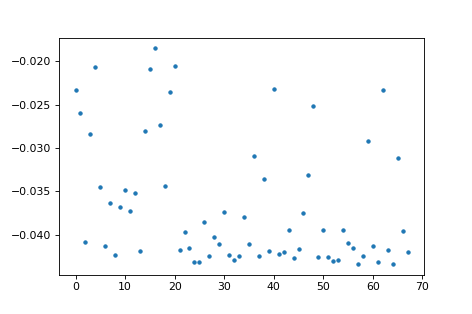

In [723]:
plt.figure()
plt.plot(
    study.trials_dataframe()['value'], 
    '.',
#     color=study.trials_dataframe()['number']
)

In [805]:
labels = clusterer.fit(
    session_bool=data.sessionID_concat,
    min_cluster_size=2,
    split_intraSession_clusters=True,
    discard_failed_pruning=True,
    d_conj=None,
    d_cut=None,
    d_step=0.05,
    kwargs_makeConjunctiveDistanceMatrix={
        'power_sf': 0.5,
        'power_NN': 1.0,
        'power_SWT': 0.1,
        'p_norm': -4.0,
        'sig_NN_kwargs': {'mu': -1.5, 'b': 1.0},
        'sig_SWT_kwargs': {'mu': -2.0, 'b': 1.0}
    },
);
labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]


Clustering...
Making conjunctive distance matrix...
Splitting up clusters with multiple ROIs per session...


AttributeError: 'Clusterer' object has no attribute 'd_cut'

In [729]:
# results_clustering = clustering.score_labels(clusterer.labels, ucids_groundTruth, ignore_negOne=False)
# print(f"Accuracy score: {results_clustering['score_weighted_partial']}")

# # results_clustering

# print(len(np.unique(labels)), len(np.unique(ucids_groundTruth)))
# print((labels==-1).sum())
# print((ucids_groundTruth==-1).sum())

# Visualize results

In [665]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

In [766]:
(clusterer.d_conj != 0) < 0.4

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


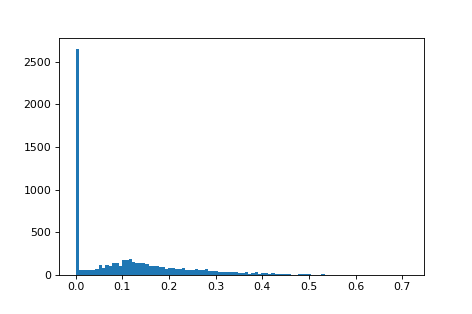

In [730]:
plt.figure()
plt.hist(clusterer.hdbs.cluster_persistence_, 100);

<IPython.core.display.Javascript object>


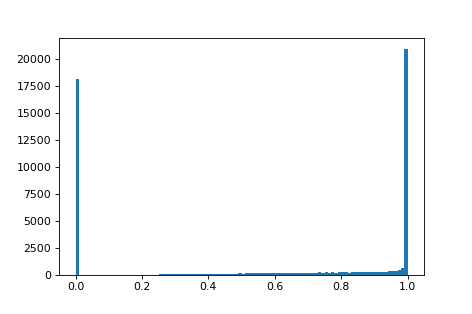

In [738]:
plt.figure()
plt.hist(clusterer.hdbs.probabilities_, 100);

In [752]:
clusterer.hdbs.probabilities_.shape

(51170,)

In [754]:
clusterer.hdbs.cluster_persistence_.shape

(6900,)

In [758]:
labels2 = labels.copy()
labels2[clusterer.hdbs.probabilities_[:-1] > 0.99] = -1

In [731]:
labels2 = labels.copy()
labels2[np.isin(labels, np.where(clusterer.hdbs.cluster_persistence_[:-1] < 0.1)[0])] = -1

In [759]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels2,
    confidence=None,
)

<IPython.core.display.Javascript object>


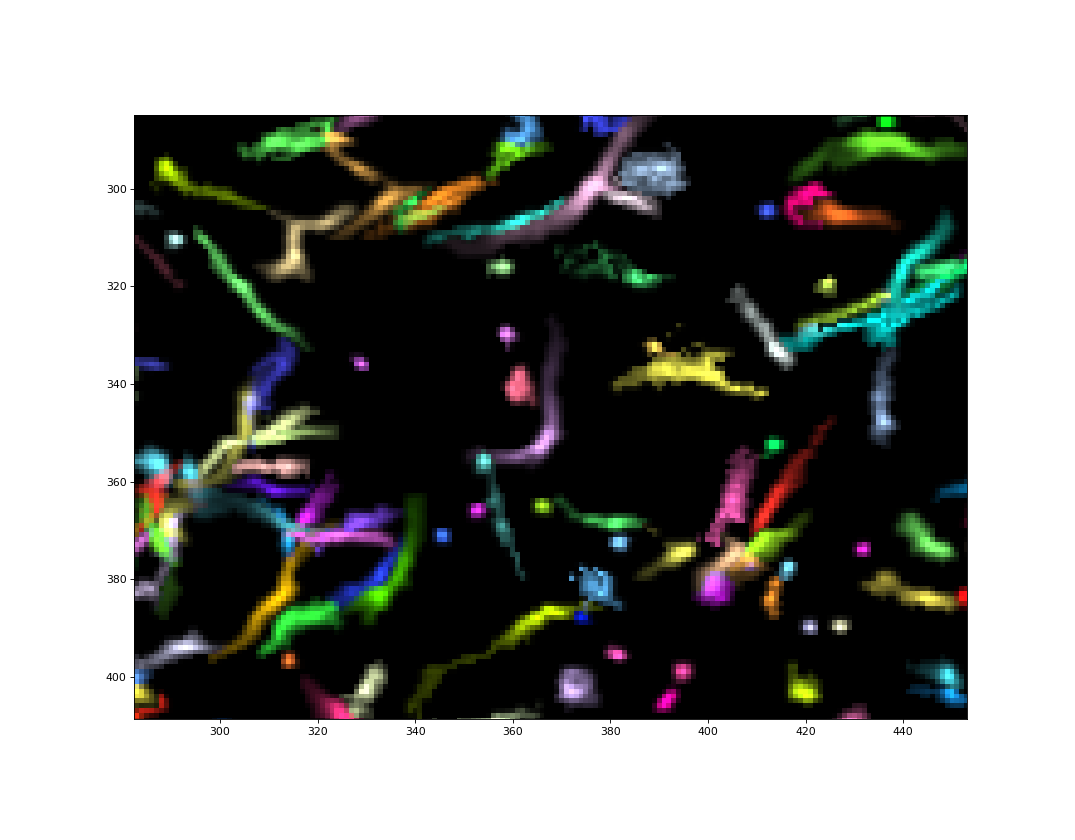

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [760]:
%matplotlib notebook
visualization.display_toggle_image_stack(FOV_clusters)

In [266]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

In [54]:
import scipy
from tqdm import tqdm

In [57]:
h, w = data.FOV_height, data.FOV_width

boolSessionID = data.sessionID_concat

rois = scipy.sparse.vstack(aligner.ROIs_aligned)
rois = rois.multiply(1.2/rois.max(1).A).power(1)

u, c = np.unique(labels, return_counts=True)

n_c = len(u)
n_p = rois.shape[1]

colors = helpers.rand_cmap(nlabels=n_c, verbose=False)(np.linspace(0.,1.,n_c, endpoint=False))

if np.isin(-1, labels):
    colors[0] = [0,0,0,0]

labels_squeezed = helpers.squeeze_integers(labels)
labels_squeezed -= labels_squeezed.min()

rois_c = scipy.sparse.hstack([rois.multiply(colors[labels_squeezed, ii][:,None]) for ii in range(4)]).tocsr()
rois_c.data = np.minimum(rois_c.data, 1)

rois_c_bySessions = [rois_c[idx] for idx in boolSessionID.T]

rois_c_bySessions_FOV = [r.max(0).toarray().reshape(4, h, w).transpose(1,2,0)[:,:,:3] for r in rois_c_bySessions]


<IPython.core.display.Javascript object>


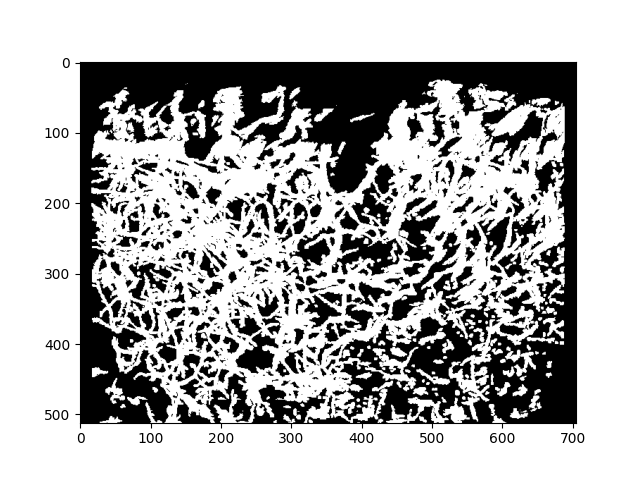

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [56]:
visualization.display_toggle_image_stack(rois_c_bySessions_FOV)

/tmp/ipykernel_4562/2710547728.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


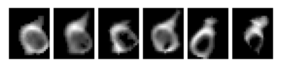

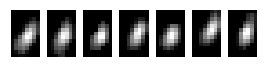

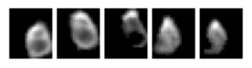

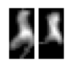

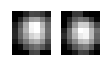

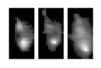

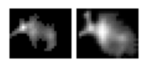

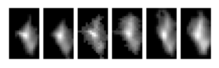

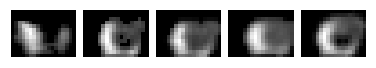

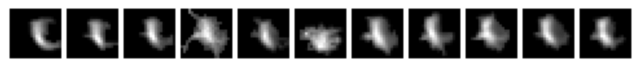

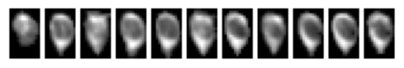

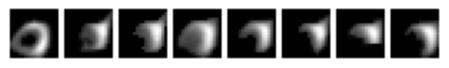

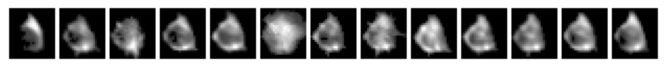

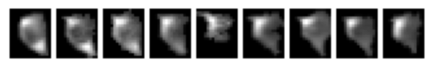

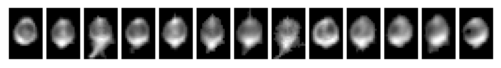

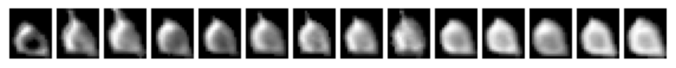

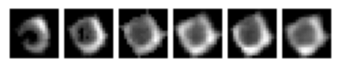

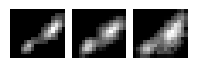

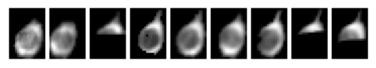

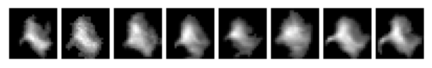

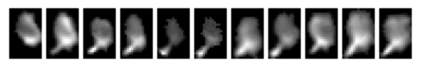

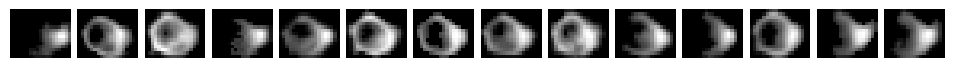

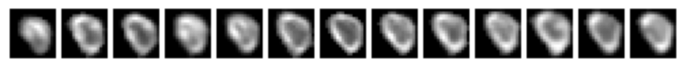

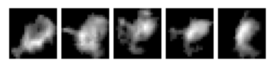

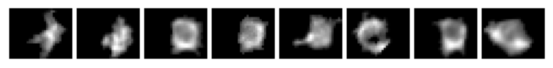

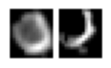

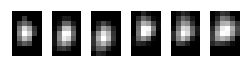

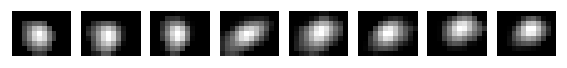

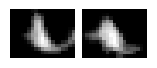

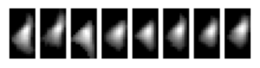

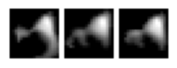

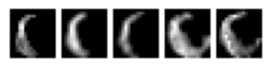

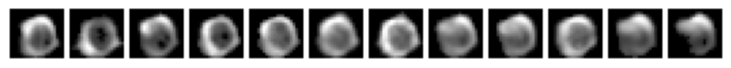

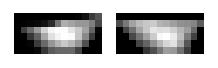

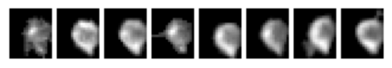

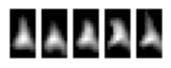

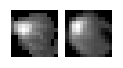

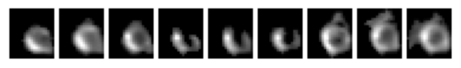

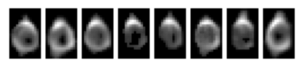

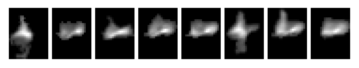

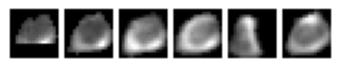

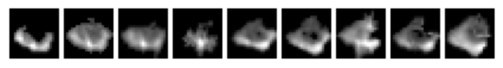

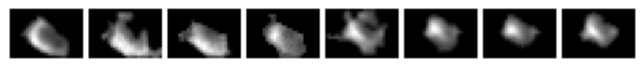

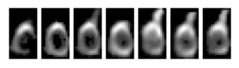

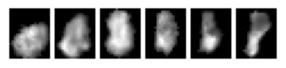

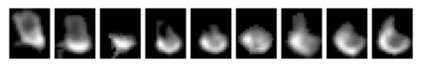

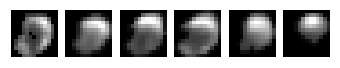

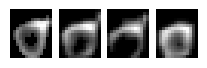

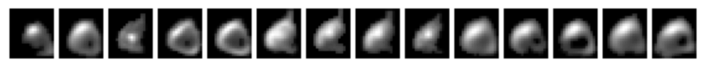

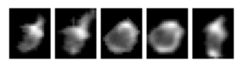

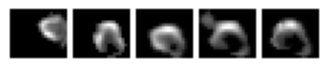

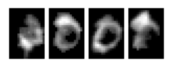

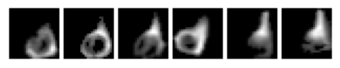

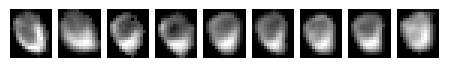

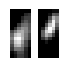

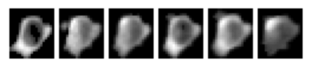

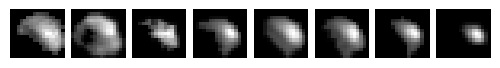

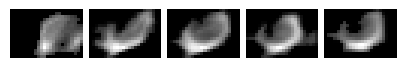

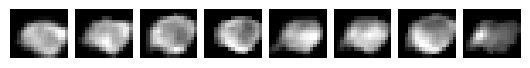

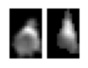

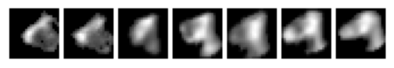

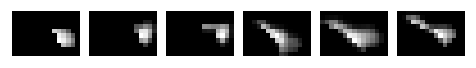

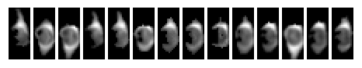

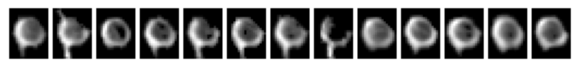

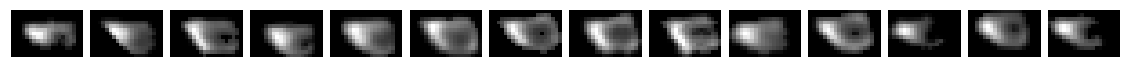

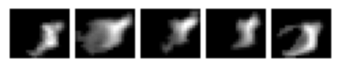

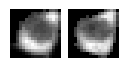

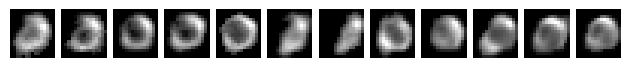

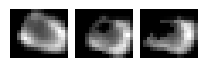

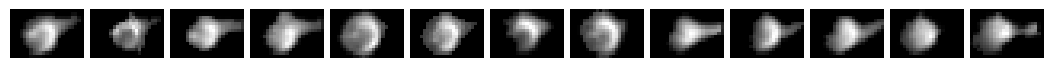

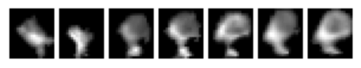

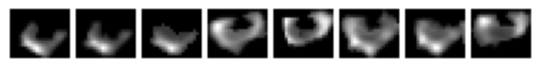

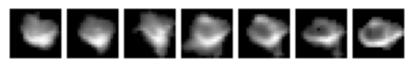

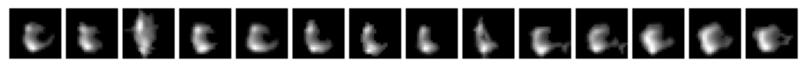

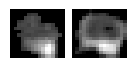

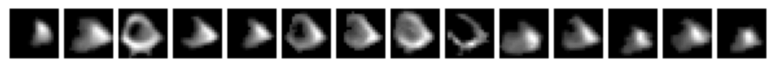

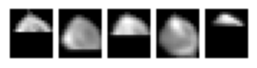

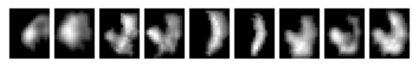

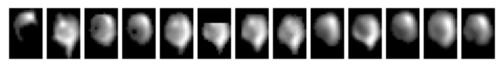

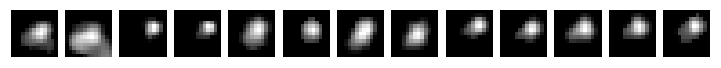

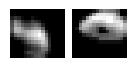

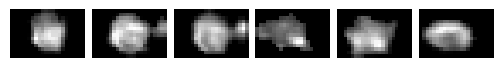

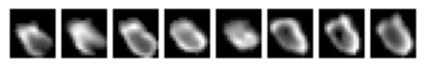

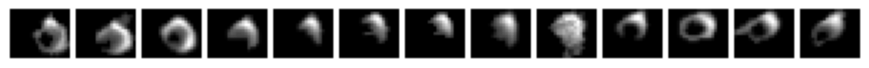

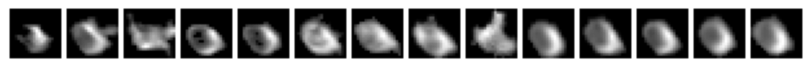

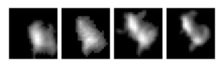

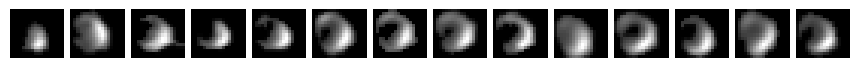

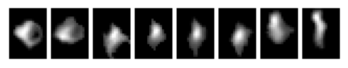

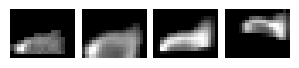

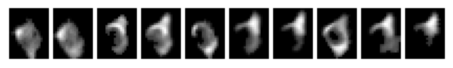

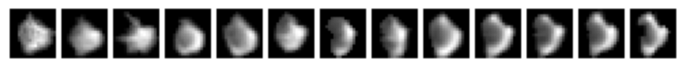

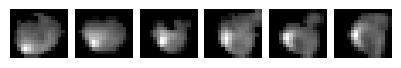

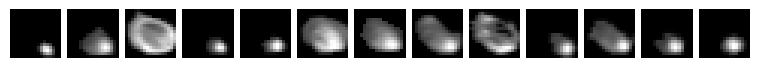

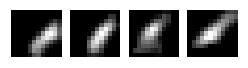

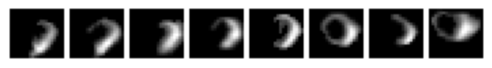

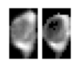

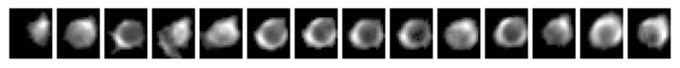

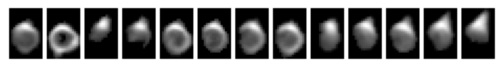

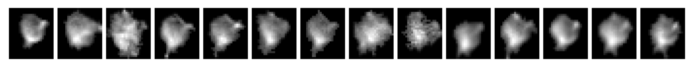

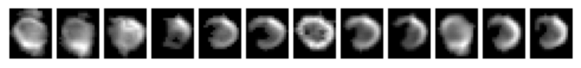

In [111]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

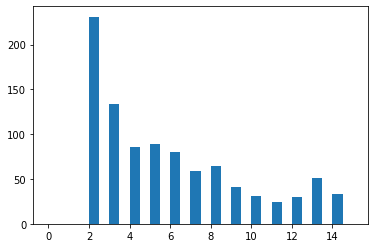

In [114]:
_, counts = np.unique(ucids, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


# Save results

In [129]:
dir_save = Path('/home/rich/Desktop/').resolve()
name_save = dir_allOuterFolders.name
path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')

In [143]:
ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
}

helpers.simple_save(
    obj=results,
    filename=path_save,
    mkdir=True,
)

In [115]:
import scipy.io

In [116]:
test = scipy.io.loadmat('/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/NOAH_alignment_ground_truth/NY044_manually_aligned.mat', simplify_cells=True)

In [117]:
test['this_mouse']['ud']['sismat']

array([[ nan,  nan, 282., ...,  63.,  70.,  77.],
       [ 85., 359.,  nan, ...,  nan,  nan,  nan],
       [399.,  70.,  nan, ...,  nan,  nan,  nan],
       ...,
       [182., 310.,  nan, ..., 161., 324., 335.],
       [511.,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [118]:
sismat = test['this_mouse']['ud']['sismat']

In [119]:
ucid_gt = [np.ones(data.n_roi[ii])*-1 for ii in range(data.n_sessions)]

for sesh in range(sismat.shape[1]):
    for ii in range(sismat.shape[0]):
        idx = sismat[:,sesh][ii] -1
        if np.isnan(idx) == False:
#             print(sesh, idx, ii)
            ucid_gt[sesh][int(idx)] = ii

In [120]:
_, counts = np.unique(np.concatenate(ucid_gt), return_counts=True)

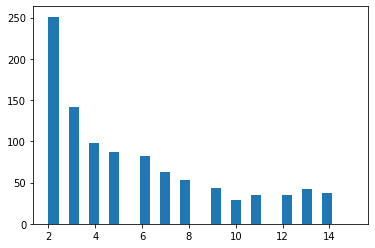

In [123]:
plt.figure()
plt.hist(counts, 30, range=(2, data.n_sessions+1));

<IPython.core.display.Javascript object>


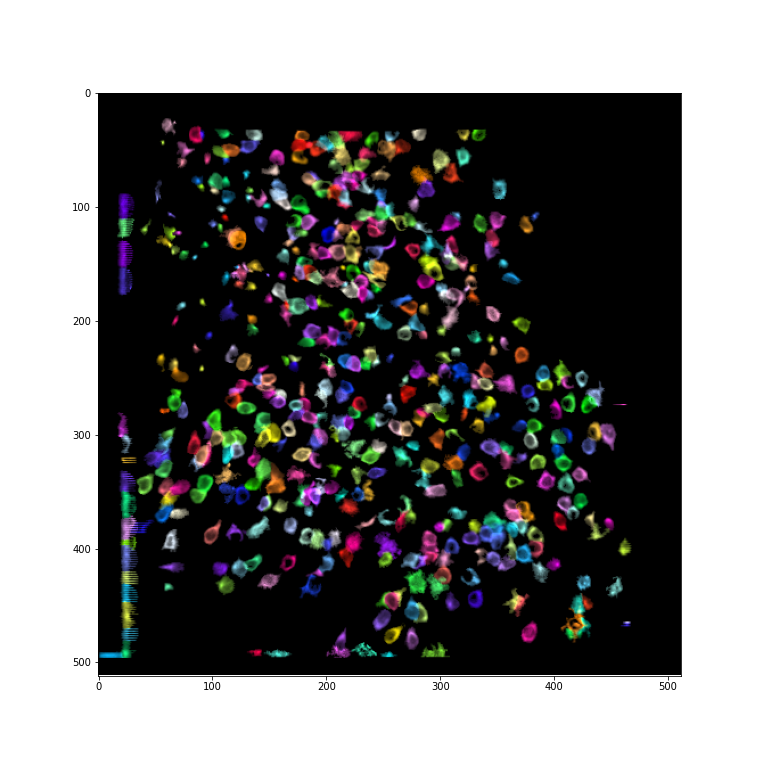

interactive(children=(IntSlider(value=0, description='i_frame', max=13), Output()), _dom_classes=('widget-inte…

In [367]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    preds=np.concatenate(ucid_gt),
    confidence=None,
    threshold_confidence = 0.5
)

visualization.display_toggle_image_stack(FOV_clusters)

In [ ]:
np.random.normal()

<IPython.core.display.Javascript object>


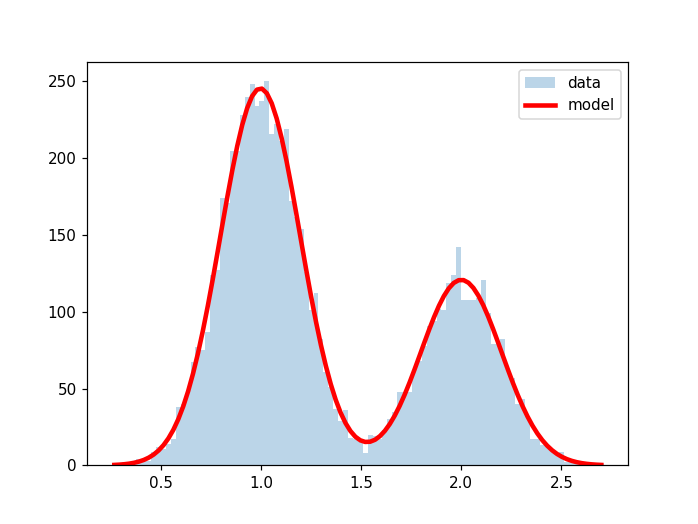

[9.97421912e-01 1.99759951e-01 2.45497064e+02 2.00006200e+00
 2.02499854e-01 1.20828308e+02] 
 [2.24550472e-03 2.25814749e-03 2.38938955e+00 4.59344291e-03
 4.61978447e-03 2.37326641e+00]


In [70]:
# from pylab import *
import scipy.optimize
plt.figure()

data=np.concatenate((np.random.normal(1,.2,5000),np.random.normal(2,.2,2500)))
y,x,_=plt.hist(data,100,alpha=.3,label='data')

x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected=(1,.2,250,2,.2,125)
params,cov=scipy.optimize.curve_fit(bimodal,x,y,expected)
sigma=np.sqrt(cov.diagonal())

plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
plt.legend()
print(params,'\n',sigma)    